In [1]:
%cd "D:\Users\sean.ogara\Documents\ons-energy-analysis"

d:\Users\sean.ogara\Documents\ons-energy-analysis


In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from src.visualisations.scatter_chart import scatter_chart

In [3]:
electricity_price_data = pd.read_csv("data/processed/global_electricity_household_prices.csv")
electricity_price_data.head()

,country,iso2,iso3,price
0,Lebanon,LB,LBN,0.001
1,Iran,IR,IRN,0.002
2,Syria,SY,SYR,0.004
3,Ethiopia,ET,ETH,0.005
4,Sudan,SD,SDN,0.007


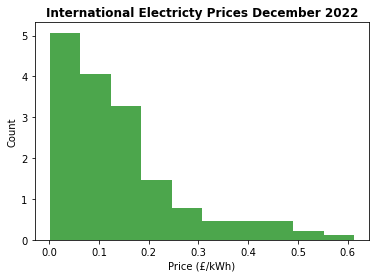

In [4]:
#distribution of prices
num_bins = 10
n, bins, patches = plt.hist(electricity_price_data['price'], num_bins,
                            density = 1,
                            color ='green',
                            alpha = 0.7)

plt.xlabel('Price (£/kWh)')
plt.ylabel('Count')
plt.title('International Electricty Prices December 2022',
          fontweight = 'bold')
plt.show()

In [5]:
#global mean price
global_mean_price = electricity_price_data['price'].mean()
global_mean_price

0.13707586206896552

In [6]:
#uk price
uk_price = electricity_price_data[electricity_price_data['iso2'] == 'GB']['price'].values[0]
uk_price

0.387

In [7]:
#ratio between uk and global mean
uk_price / global_mean_price

2.823254175890521

In [8]:
#bring in energy mix data
energy_mix_data = pd.read_csv("data/raw/owid-energy-data.csv")
energy_mix_data.tail()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
22007,Zimbabwe,2018,ZWE,15052191.0,2.271535e+10,NaN,NaN,NaN,NaN,25.910,...,0.218,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22008,Zimbabwe,2019,ZWE,15354606.0,NaN,NaN,NaN,NaN,NaN,24.748,...,0.364,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22009,Zimbabwe,2020,ZWE,15669663.0,NaN,NaN,NaN,NaN,NaN,22.336,...,0.395,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22010,Zimbabwe,2021,ZWE,15993525.0,NaN,NaN,NaN,NaN,NaN,23.760,...,0.498,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22011,Zimbabwe,2022,ZWE,16320539.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#filter for 2021 as this is the most recent complete data
energy_mix_2021 = energy_mix_data.loc[energy_mix_data['year'] == 2021, :]
energy_mix_2021.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
21,ASEAN (Ember),2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.983,NaN,NaN,NaN,NaN,NaN,8.30,NaN,0.719,NaN
144,Afghanistan,2021,AFG,4.009946e+07,NaN,NaN,NaN,NaN,NaN,0.000,...,9.639,NaN,NaN,NaN,NaN,0.000,0.00,NaN,0.000,NaN
266,Africa,2021,NaN,1.393677e+09,NaN,27.27,0.238,0.796,1.11,2.705,...,2.040,0.835,19.233,9.431,59.609,14.989,20.89,42.771,2.489,1.062
324,Africa (EI),2021,NaN,NaN,NaN,27.27,0.238,NaN,1.11,NaN,...,1.996,0.835,19.233,9.432,59.609,NaN,22.78,NaN,2.540,1.062
347,Africa (Ember),2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.040,NaN,NaN,NaN,NaN,NaN,20.89,NaN,2.489,NaN


In [10]:
#fileter for columns of interest
cols_of_interest = [
                    'country', 
                    'year',
                    'iso_code',
                    'population',
                    'gdp',
                    'energy_per_capita',
                    'fossil_elec_per_capita',
                    'low_carbon_energy_per_capita',
                    'low_carbon_share_energy',
                    'gas_prod_per_capita',
                    'oil_prod_per_capita',
                    'gas_production',
                    'oil_production'
                    ]           
energy_mix_2021 = energy_mix_2021[cols_of_interest]

<AxesSubplot:>

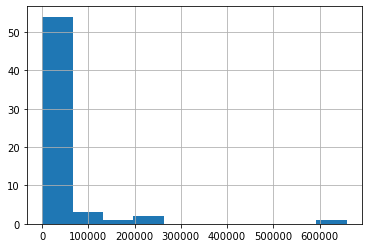

In [11]:
energy_mix_2021['gas_prod_per_capita'].hist()

<AxesSubplot:>

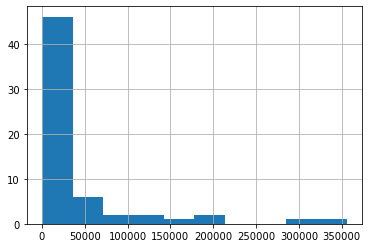

In [12]:
energy_mix_2021['oil_prod_per_capita'].hist()

<AxesSubplot:>

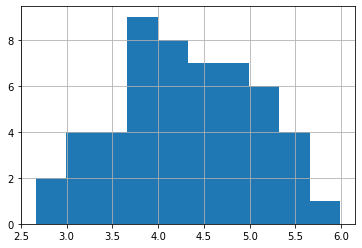

In [13]:
#combine oil and gas energy production per cap for total and log to make normally distributed
energy_mix_2021['oil_and_gas_prod_per_capita'] = energy_mix_2021['oil_prod_per_capita'] + energy_mix_2021['gas_prod_per_capita']
energy_mix_2021['oil_and_gas_prod_per_capita_log'] = np.log10(energy_mix_2021['oil_prod_per_capita'] + energy_mix_2021['gas_prod_per_capita'])
energy_mix_2021['oil_and_gas_prod_per_capita_log'].hist()

In [14]:
#join with price data
joined_energy_data =pd.merge(left=electricity_price_data[['iso3', 'price']], right=energy_mix_2021, left_on='iso3', right_on='iso_code')

In [15]:
scatter_chart(data=joined_energy_data, x_var='oil_and_gas_prod_per_capita_log', y_var='price', x_label='Oil and gas production per capita log(tWH)', y_label='Price (£/kWh)', hover_labels='country')

d:\Python37\lib\site-packages\scipy\__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4



In [17]:
scatter_chart(data=joined_energy_data, x_var='low_carbon_share_energy', y_var='price', x_label='Low carbon energy share (%)', y_label='Price (£/kWh)', hover_labels='country')

In [19]:
#europe only
europe_country_codes = [
    'ALB', 'ARM', 'BLR', 'BIH', 'FRO', 'GEO', 'GIB', 'ISL', 'IMN', 'XKX', 'LIE', 'MKD',
    'MDA', 'MCO', 'MNE', 'NOR', 'RUS', 'SMR', 'SRB', 'CHE', 'TUR', 'UKR', 'GBR', 'VAT',
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC',
    'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK',
    'SVN', 'ESP', 'SWE'
]

scatter_chart(data=joined_energy_data[joined_energy_data['iso3'].isin(europe_country_codes)], x_var='low_carbon_share_energy', y_var='price', x_label='Low carbon energy share (%)', y_label='Price (£/kWh)', hover_labels='country')